<a href="https://colab.research.google.com/github/BrandonHT/COVID-19-estimator/blob/main/COVID-19_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aprendizaje de Máquina - diciembre 2020**

**Proyecto final: predicción de gravedad de contagios de COVID-19 en México.**

*   Andrea Marín Alarcón
*   Brandon Francisco Hernández Troncoso

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# balanceo de datos
from imblearn import under_sampling, over_sampling
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek

# librerias para modelos
from sklearn import tree
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# evaluacion de modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix, f1_score

# kmeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

# cargar archivo
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/My Drive/ML/201107COVID19MEXICO.csv', encoding='latin')

# Limpiar el dataframe

In [ ]:
df.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA', 'RESULTADO_LAB', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

In [ ]:
columns = ['SEXO', 'ENTIDAD_RES', 'TIPO_PACIENTE',
           'FECHA_SINTOMAS', 'FECHA_DEF', 'NEUMONIA',
           'EDAD', 'EMBARAZO', 'INDIGENA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 
           'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 
           'TABAQUISMO','UCI', 'CLASIFICACION_FINAL']
df = df[columns]

Mapeo de variables

In [ ]:
clasificacion_map = {
    1: 'Positivo',
    2: 'Positivo',
    3: 'Positivo',
    7: 'Negativo'
}
df['CLASIFICACION_FINAL'] =  df['CLASIFICACION_FINAL'].map(clasificacion_map)

In [ ]:
sexo_map = {
    1: 1,
    2: 0
}
df['SEXO'] =  df['SEXO'].map(sexo_map)

In [ ]:
paciente_map = {
    1: 'Ambulatorio',
    2: 'Hospitalizado'
}
df['TIPO_PACIENTE'] =  df['TIPO_PACIENTE'].map(paciente_map)

In [ ]:
yn_map = {
    1: 1,
    2: 0,
    97: 0
}
df['NEUMONIA'] =  df['NEUMONIA'].map(yn_map)
df['EMBARAZO'] =  df['EMBARAZO'].map(yn_map)
df['INDIGENA'] =  df['INDIGENA'].map(yn_map)
df['DIABETES'] =  df['DIABETES'].map(yn_map)
df['EPOC'] =  df['EPOC'].map(yn_map)
df['ASMA'] =  df['ASMA'].map(yn_map)
df['INMUSUPR'] =  df['INMUSUPR'].map(yn_map)
df['HIPERTENSION'] =  df['HIPERTENSION'].map(yn_map)
df['CARDIOVASCULAR'] =  df['CARDIOVASCULAR'].map(yn_map)
df['OBESIDAD'] =  df['OBESIDAD'].map(yn_map)
df['EPOC'] =  df['EPOC'].map(yn_map)
df['RENAL_CRONICA'] =  df['RENAL_CRONICA'].map(yn_map)
df['TABAQUISMO'] =  df['TABAQUISMO'].map(yn_map)

In [ ]:
uci_map = {
    1: 'UCI',
    2: 'NO',
    97: 'NO'
}
df['UCI'] =  df['UCI'].map(uci_map)

In [ ]:
defuncion_map = {
    '9999-99-99': 'Vivo'
}
df['FECHA_DEF'] = df['FECHA_DEF'].map(defuncion_map)
df['FECHA_DEF'] = df['FECHA_DEF'].fillna('Fallecido')

In [ ]:
#municipios_df = pd.read_csv('drive/My Drive/ML/municipios.csv')
#municipios_df = municipios_df[municipios_df['CLAVE_MUNICIPIO'] < 900]
#dfs = []
#for entidad in municipios_df['CLAVE_ENTIDAD'].unique():
#  entidad_df = municipios_df[municipios_df['CLAVE_ENTIDAD'] == entidad]
#  municipios_map = {x['CLAVE_MUNICIPIO']: x['MUNICIPIO'] for i, x in entidad_df.iterrows()}
#  df.loc[df['ENTIDAD_RES'] == entidad, 'MUNICIPIO_RES'] = df.loc[df['ENTIDAD_RES'] == entidad, 'MUNICIPIO_RES'].map(municipios_map)

In [ ]:
entidad_map = {
1: 'AGUASCALIENTES',
2: 'BAJA CALIFORNIA',
3: 'BAJA CALIFORNIA SUR',
4: 'CAMPECHE',
5: 'COAHUILA DE ZARAGOZA',
6: 'COLIMA',
7: 'CHIAPAS',
8: 'CHIHUAHUA',
9: 'CIUDAD DE MÉXICO',
10: 'DURANGO',
11: 'GUANAJUATO',
12: 'GUERRERO',
13: 'HIDALGO',
14: 'JALISCO',
15: 'MÉXICO',
16: 'MICHOACÁN DE OCAMPO',
17: 'MORELOS',
18: 'NAYARIT',
19: 'NUEVO LEÓN',
20: 'OAXACA',
21: 'PUEBLA',
22: 'QUERÉTARO',
23: 'QUINTANA ROO',
24: 'SAN LUIS POTOSÍ',
25: 'SINALOA',
26: 'SONORA',
27: 'TABASCO',
28: 'TAMAULIPAS',
29: 'TLAXCALA',
30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
31: 'YUCATÁN',
32: 'ZACATECAS',
36: 'ESTADOS UNIDOS MEXICANOS'}
df['ENTIDAD_RES'] = df['ENTIDAD_RES'].map(entidad_map)

## Crear DataFrame limpio

In [ ]:
## quitar registros que no sean positivos ni negativos
clean_df = df.dropna(subset = ['CLASIFICACION_FINAL'])
## quitar registros despues de octubre
clean_df = clean_df[clean_df['FECHA_SINTOMAS'] < '2020-10-01']

In [ ]:
## crear variable de clasificacion final
conditions = [
  clean_df['CLASIFICACION_FINAL'] == 'Negativo',
  (clean_df['CLASIFICACION_FINAL'] == 'Positivo') & (clean_df['TIPO_PACIENTE'] == 'Ambulatorio')  & (clean_df['FECHA_DEF'] == 'Vivo'),
  (clean_df['CLASIFICACION_FINAL'] == 'Positivo') & (clean_df['FECHA_DEF'] == 'Fallecido'),
  (clean_df['CLASIFICACION_FINAL'] == 'Positivo') & (clean_df['UCI'] == 'UCI') & (clean_df['FECHA_DEF'] == 'Vivo'),
  (clean_df['CLASIFICACION_FINAL'] == 'Positivo') & (clean_df['TIPO_PACIENTE'] == 'Hospitalizado') & (clean_df['UCI'] != 'UCI')  & (clean_df['FECHA_DEF'] == 'Vivo')
]

choices = [4, 0, 3, 2,1]#['Negativo', 'Ambulatorio', 'Fallecido', 'UCI', 'Hospitalizado']

clean_df['CLASIFICACION'] = np.select(conditions, choices, default=pd.NA)
clean_df = clean_df.drop(columns = ['CLASIFICACION_FINAL', 'UCI', 'TIPO_PACIENTE', 'FECHA_DEF', 'FECHA_SINTOMAS'])

In [ ]:
variables = ['NEUMONIA', 'DIABETES', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO']
clean_df = clean_df.dropna(subset=variables, how = 'any')
clean_df = clean_df.reset_index(drop = True)

## Gráficas

<function matplotlib.pyplot.savefig>

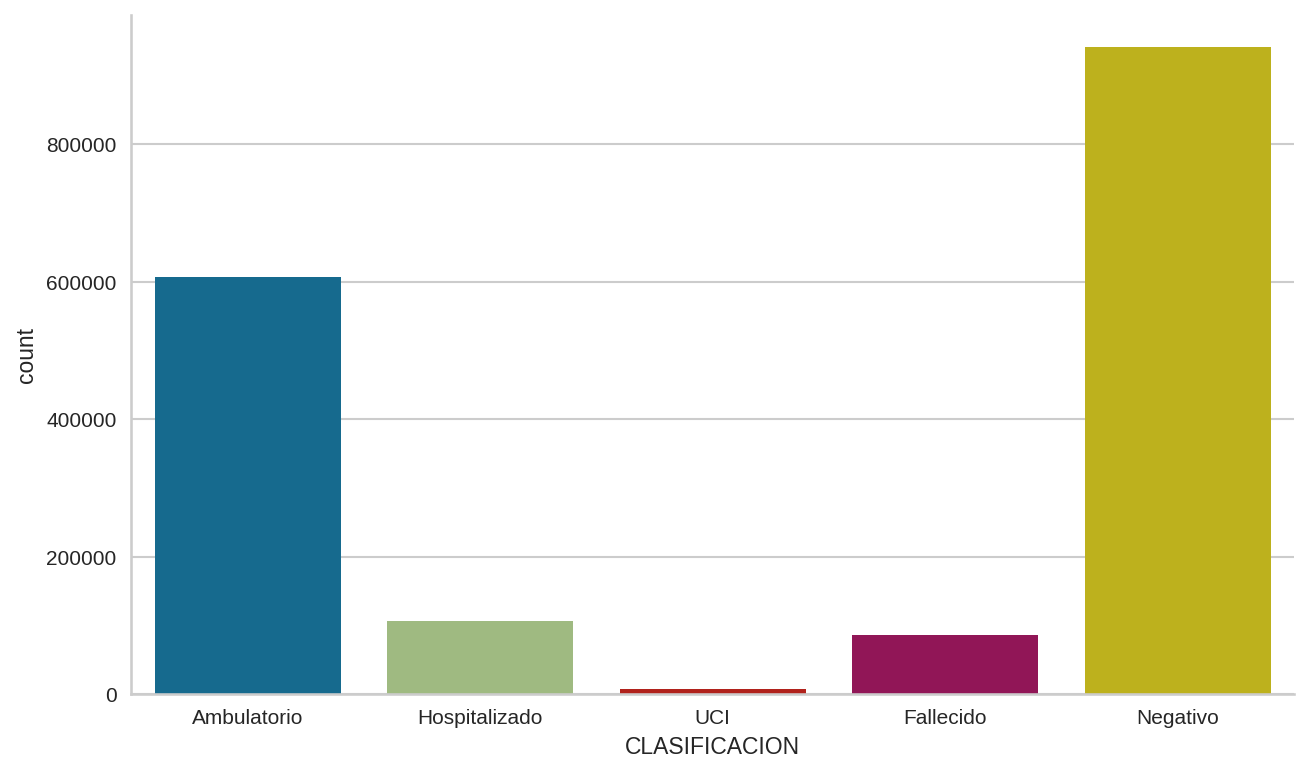

In [ ]:
positive_df = clean_df[clean_df['CLASIFICACION'] != 'Negativo']
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(ax = ax, x = 'CLASIFICACION', data = clean_df)
ax.set_xticklabels(['Ambulatorio', 'Hospitalizado', 'UCI', 'Fallecido', 'Negativo'])
sns.despine()
plt.savefig

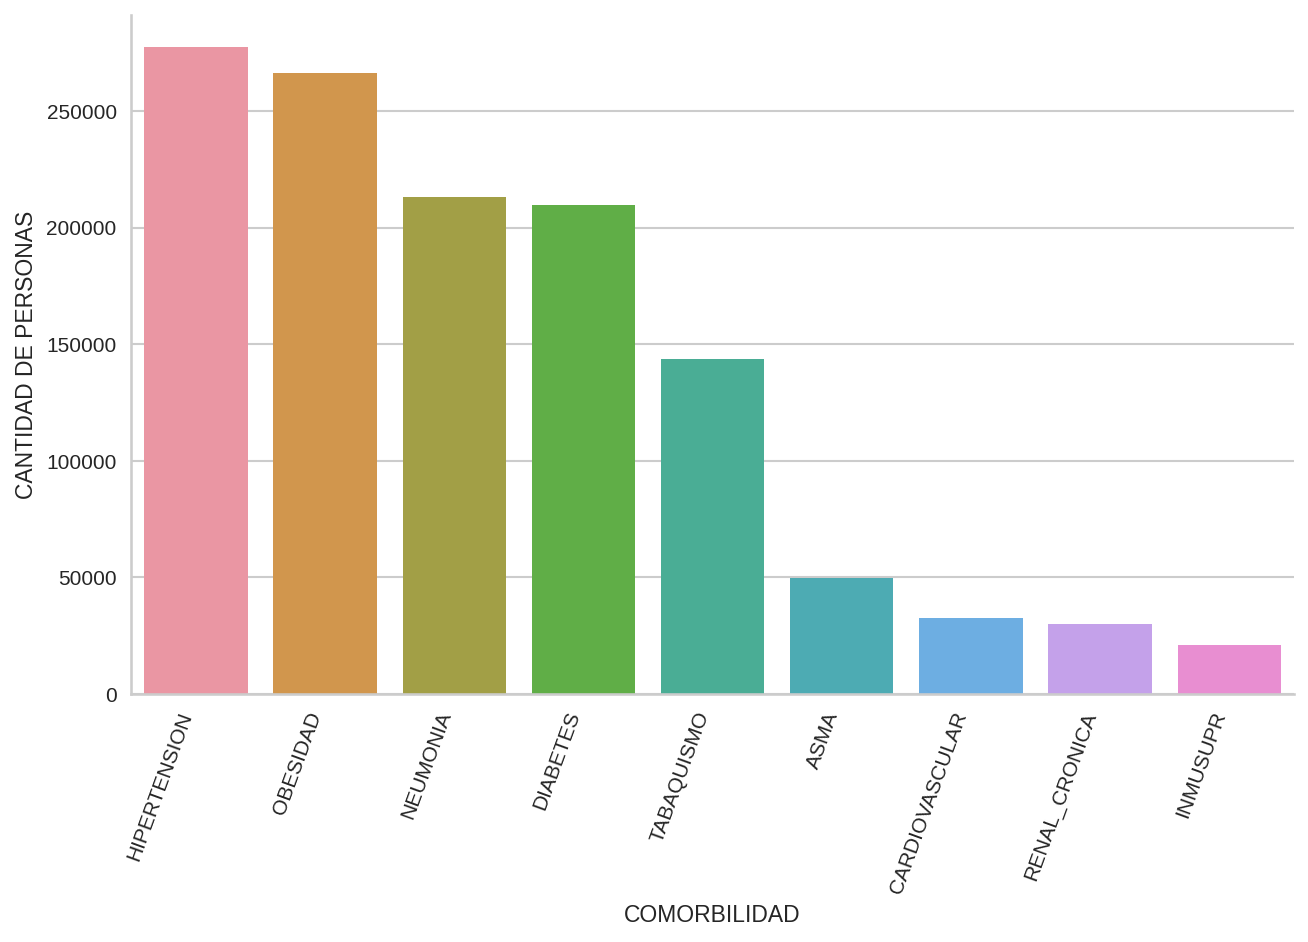

In [ ]:
comorbilidades = clean_df[variables].sum().to_dict()
aux_df = pd.DataFrame()
aux_df['COMORBILIDAD'] = comorbilidades.keys()
aux_df['CANTIDAD DE PERSONAS'] = comorbilidades.values()
aux_df.sort_values(by = 'CANTIDAD DE PERSONAS', ascending=False, inplace = True)
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.barplot(ax = ax, x = 'COMORBILIDAD', y = 'CANTIDAD DE PERSONAS', data = aux_df)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 70,
                   horizontalalignment='right')
sns.despine()

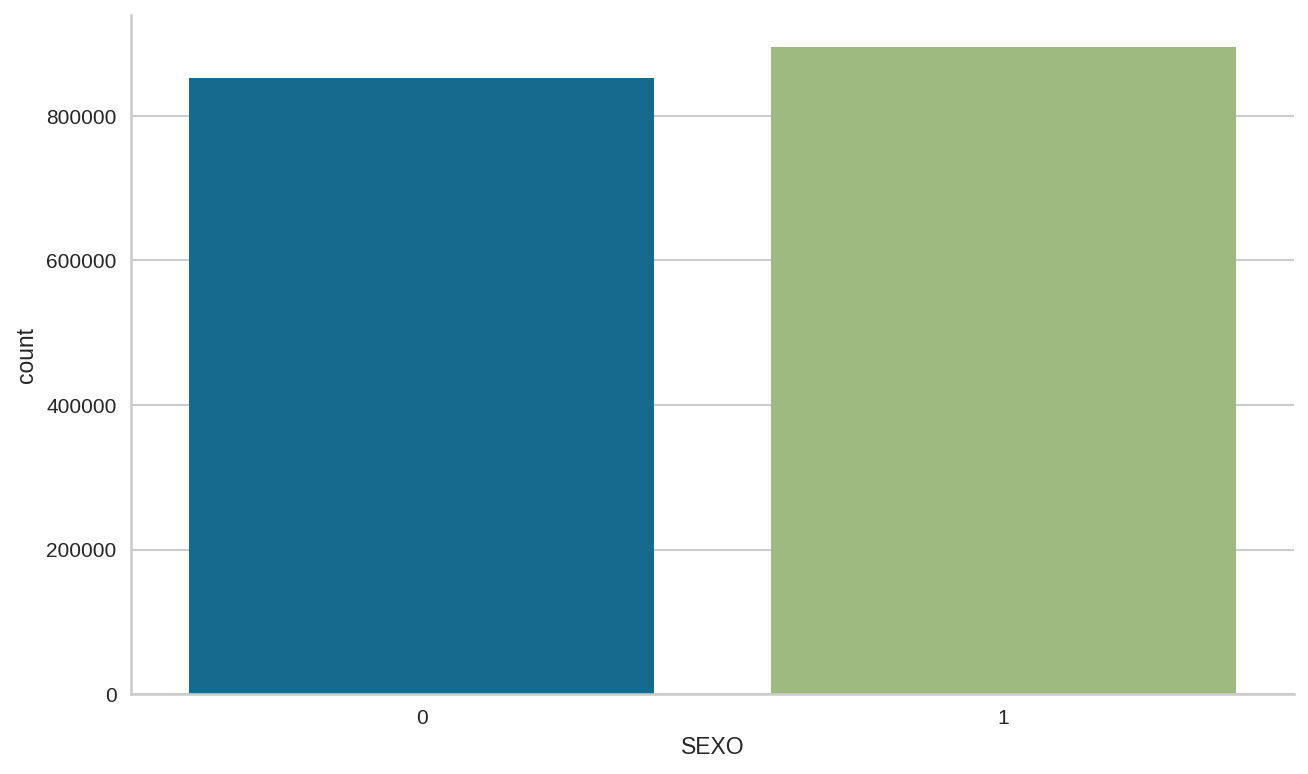

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(ax = ax, x = 'SEXO', data = clean_df)
sns.despine()

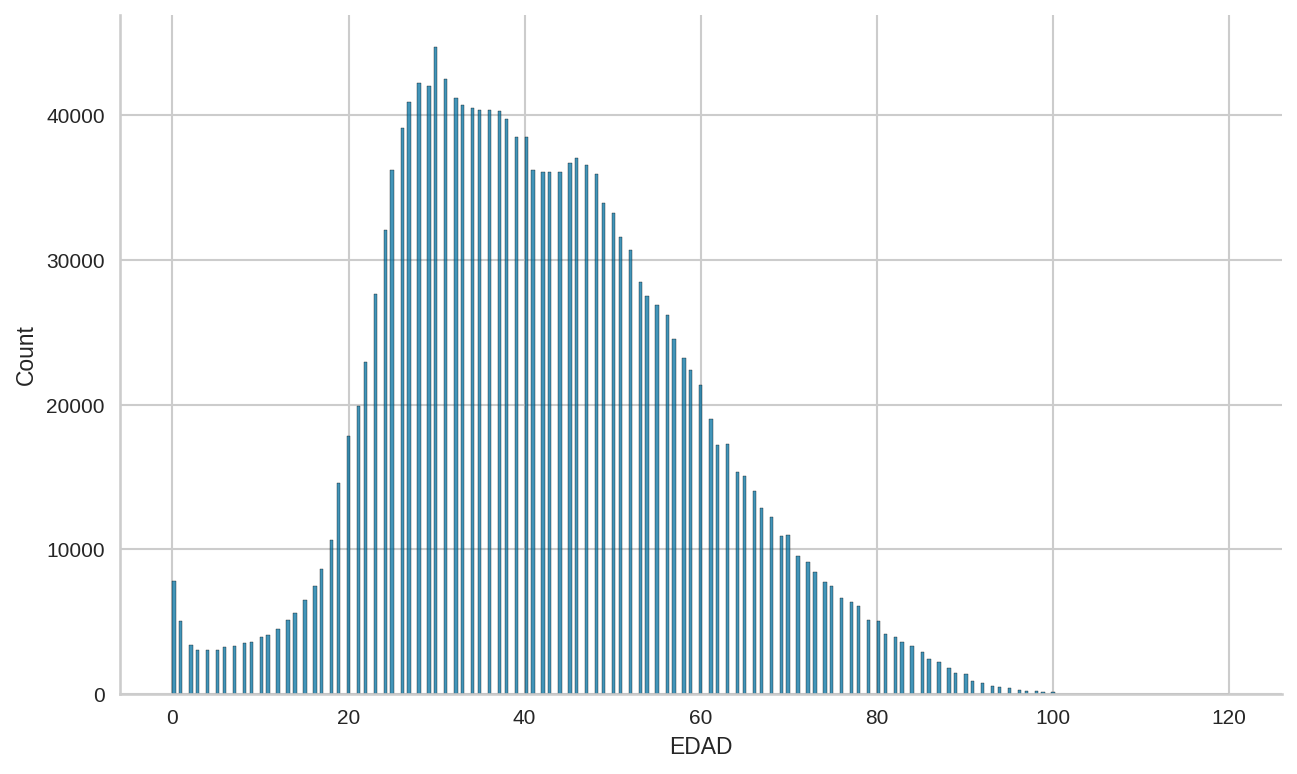

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.histplot(ax = ax, x = 'EDAD', data = clean_df)
sns.despine()

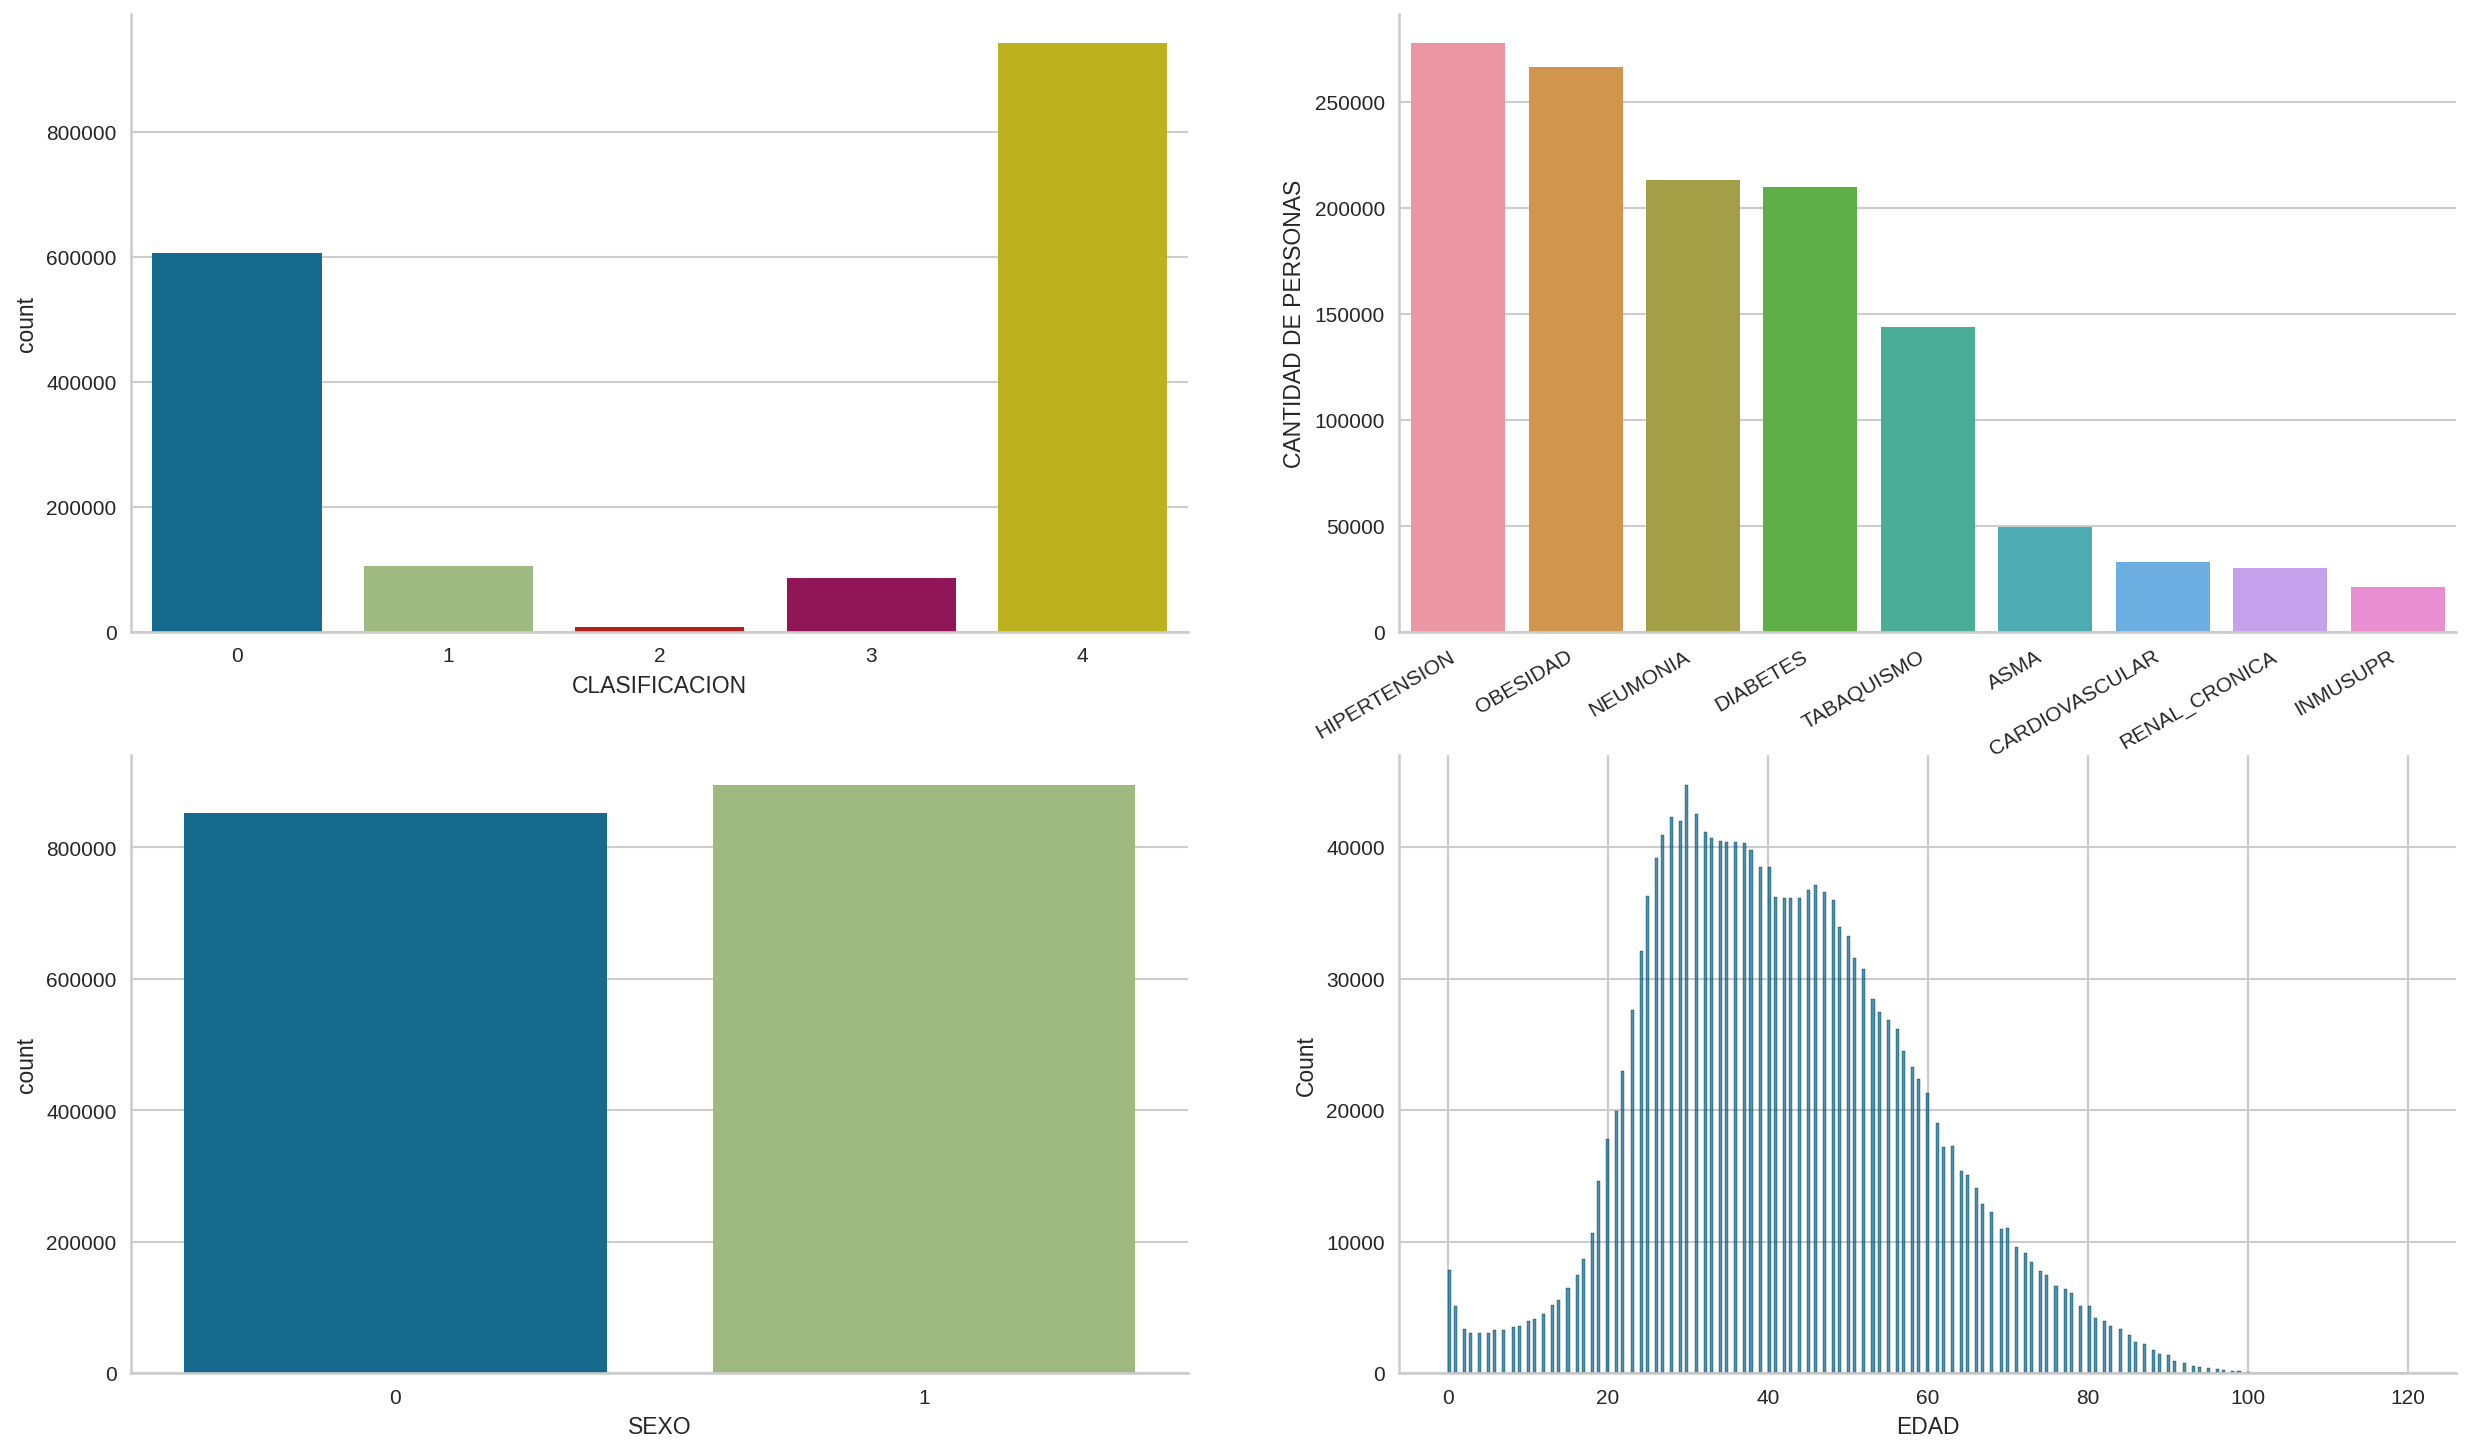

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20, 12), dpi = 150)
sns.countplot(ax = axes[0][0], x = 'CLASIFICACION', data = clean_df)
sns.barplot(ax = axes[0][1], x = 'COMORBILIDAD', y = 'CANTIDAD DE PERSONAS', data = aux_df)
axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(),
                   rotation = 30,
                   horizontalalignment='right')
sns.countplot(ax = axes[1][0], x = 'SEXO', data = clean_df)
sns.histplot(ax = axes[1][1], x = 'EDAD', data = clean_df)
sns.despine()

In [ ]:
clean_df[clean_df['EDAD'] == 120]

,SEXO,ENTIDAD_RES,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,CLASIFICACION
346455,0,TAMAULIPAS,0.0,120,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
487263,0,CIUDAD DE MÉXICO,0.0,120,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
1673511,1,CIUDAD DE MÉXICO,0.0,120,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4
1719470,0,SONORA,0.0,120,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1722228,1,SONORA,0.0,120,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1726690,0,SONORA,0.0,120,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1729363,1,SONORA,0.0,120,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1729856,1,SONORA,0.0,120,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1733570,1,SONORA,0.0,120,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1734522,1,SONORA,0.0,120,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


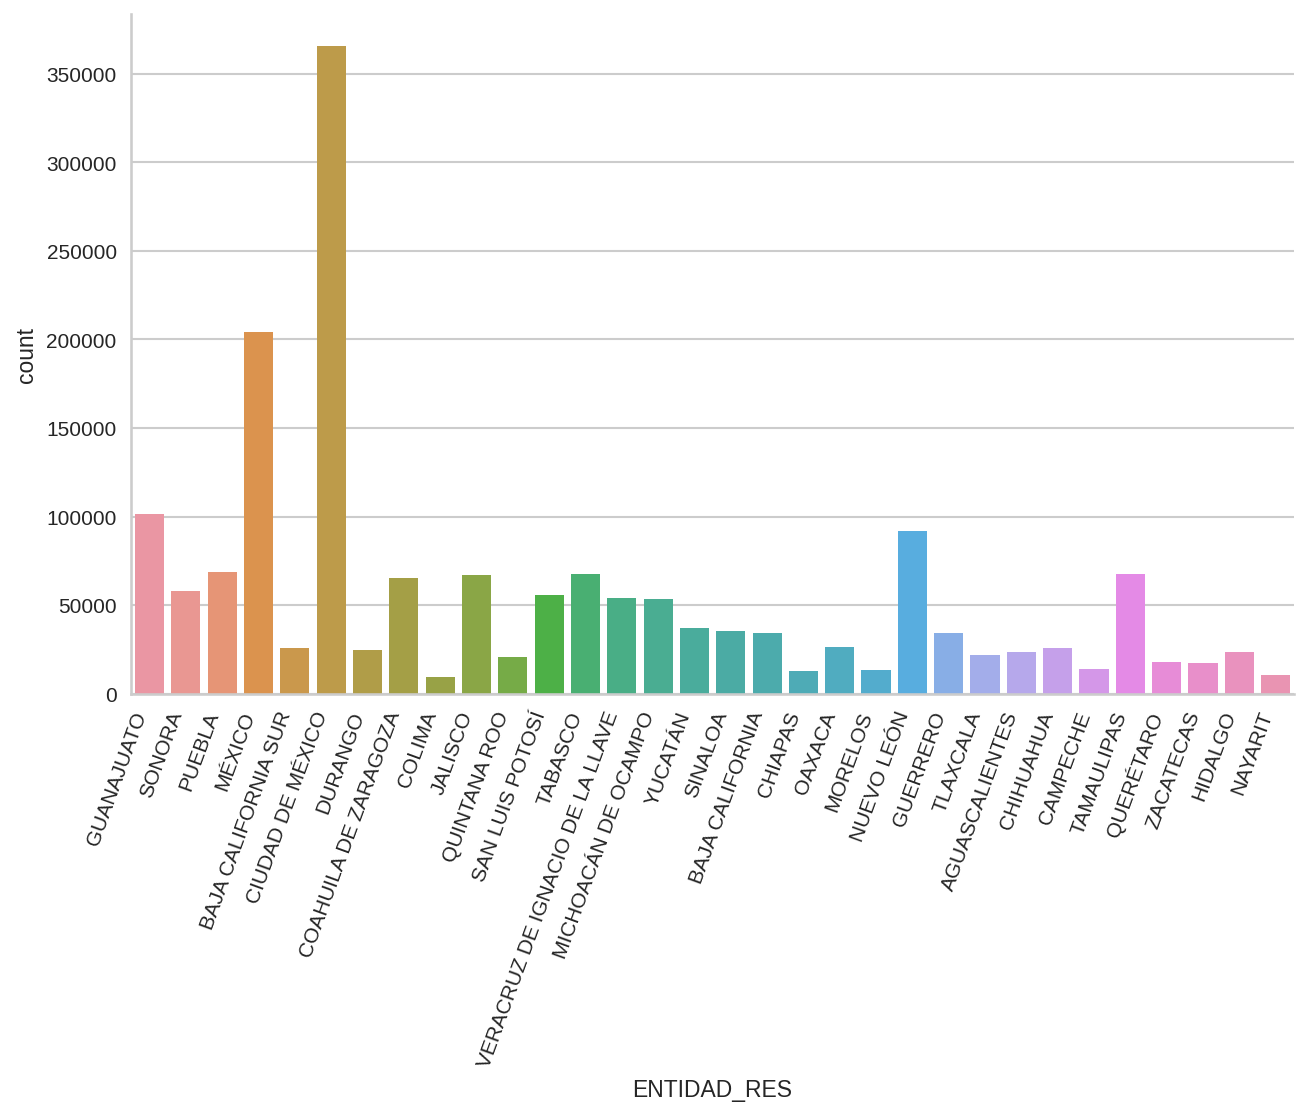

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(ax = ax, x = 'ENTIDAD_RES', data = clean_df)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 70,
                   horizontalalignment='right')
sns.despine()

## Crear dataframe final con columnas dummys

In [ ]:
clean_df.columns

Index(['SEXO', 'ENTIDAD_RES', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'CLASIFICACION'],
      dtype='object')

In [ ]:
clean_df.head()

,SEXO,ENTIDAD_RES,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,CLASIFICACION
0,0,GUANAJUATO,0.0,16,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,SONORA,1.0,47,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,PUEBLA,1.0,73,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3
3,0,MÉXICO,0.0,42,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,BAJA CALIFORNIA SUR,0.0,29,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
#final_df=pd.get_dummies(clean_df,columns=['SEXO'],drop_first=True)
final_df=pd.get_dummies(clean_df,columns=['ENTIDAD_RES'],drop_first=False)
final_df.head()

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,CLASIFICACION,ENTIDAD_RES_AGUASCALIENTES,ENTIDAD_RES_BAJA CALIFORNIA,ENTIDAD_RES_BAJA CALIFORNIA SUR,ENTIDAD_RES_CAMPECHE,ENTIDAD_RES_CHIAPAS,ENTIDAD_RES_CHIHUAHUA,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_COAHUILA DE ZARAGOZA,ENTIDAD_RES_COLIMA,ENTIDAD_RES_DURANGO,ENTIDAD_RES_GUANAJUATO,ENTIDAD_RES_GUERRERO,ENTIDAD_RES_HIDALGO,ENTIDAD_RES_JALISCO,ENTIDAD_RES_MICHOACÁN DE OCAMPO,ENTIDAD_RES_MORELOS,ENTIDAD_RES_MÉXICO,ENTIDAD_RES_NAYARIT,ENTIDAD_RES_NUEVO LEÓN,ENTIDAD_RES_OAXACA,ENTIDAD_RES_PUEBLA,ENTIDAD_RES_QUERÉTARO,ENTIDAD_RES_QUINTANA ROO,ENTIDAD_RES_SAN LUIS POTOSÍ,ENTIDAD_RES_SINALOA,ENTIDAD_RES_SONORA,ENTIDAD_RES_TABASCO,ENTIDAD_RES_TAMAULIPAS,ENTIDAD_RES_TLAXCALA,ENTIDAD_RES_VERACRUZ DE IGNACIO DE LA LLAVE,ENTIDAD_RES_YUCATÁN,ENTIDAD_RES_ZACATECAS
0,0,0.0,16,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,47,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,1.0,73,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0.0,42,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.0,29,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
final_df['CLASIFICACION'].unique()

array([0, 1, 3, 2, 4], dtype=object)

In [ ]:
# quitar epoc porque tiene muchas columnas vacías
final_df=final_df.drop(columns='EPOC')
final_df=final_df.dropna()
#normalizar la edad
min_edad = min(final_df['EDAD'])
max_edad = max(final_df['EDAD'])
final_df['EDAD']=(final_df['EDAD']-min_edad)/(max_edad - min_edad)
final_df.isna().sum()

SEXO                                           0
NEUMONIA                                       0
EDAD                                           0
EMBARAZO                                       0
INDIGENA                                       0
DIABETES                                       0
ASMA                                           0
INMUSUPR                                       0
HIPERTENSION                                   0
CARDIOVASCULAR                                 0
OBESIDAD                                       0
RENAL_CRONICA                                  0
TABAQUISMO                                     0
CLASIFICACION                                  0
ENTIDAD_RES_AGUASCALIENTES                     0
ENTIDAD_RES_BAJA CALIFORNIA                    0
ENTIDAD_RES_BAJA CALIFORNIA SUR                0
ENTIDAD_RES_CAMPECHE                           0
ENTIDAD_RES_CHIAPAS                            0
ENTIDAD_RES_CHIHUAHUA                          0
ENTIDAD_RES_CIUDAD D

In [ ]:
final_df.head()

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,CLASIFICACION,ENTIDAD_RES_AGUASCALIENTES,ENTIDAD_RES_BAJA CALIFORNIA,ENTIDAD_RES_BAJA CALIFORNIA SUR,ENTIDAD_RES_CAMPECHE,ENTIDAD_RES_CHIAPAS,ENTIDAD_RES_CHIHUAHUA,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_COAHUILA DE ZARAGOZA,ENTIDAD_RES_COLIMA,ENTIDAD_RES_DURANGO,ENTIDAD_RES_GUANAJUATO,ENTIDAD_RES_GUERRERO,ENTIDAD_RES_HIDALGO,ENTIDAD_RES_JALISCO,ENTIDAD_RES_MICHOACÁN DE OCAMPO,ENTIDAD_RES_MORELOS,ENTIDAD_RES_MÉXICO,ENTIDAD_RES_NAYARIT,ENTIDAD_RES_NUEVO LEÓN,ENTIDAD_RES_OAXACA,ENTIDAD_RES_PUEBLA,ENTIDAD_RES_QUERÉTARO,ENTIDAD_RES_QUINTANA ROO,ENTIDAD_RES_SAN LUIS POTOSÍ,ENTIDAD_RES_SINALOA,ENTIDAD_RES_SONORA,ENTIDAD_RES_TABASCO,ENTIDAD_RES_TAMAULIPAS,ENTIDAD_RES_TLAXCALA,ENTIDAD_RES_VERACRUZ DE IGNACIO DE LA LLAVE,ENTIDAD_RES_YUCATÁN,ENTIDAD_RES_ZACATECAS
0,0,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,0.391667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,1.0,0.608333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0.0,0.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0.241667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
prediction_df = final_df[final_df['CLASIFICACION'] != 4]
#prediction_df = prediction_df[prediction_df['CLASIFICACION'] != 0]

conditions = [
           prediction_df['ENTIDAD_RES_CIUDAD DE MÉXICO'] == 1,
           prediction_df['ENTIDAD_RES_MÉXICO'] == 1
]

choices = [True, True]
mask = np.select(conditions, choices, default = False)
prediction_df = prediction_df[mask] 
entidades = ['ENTIDAD_RES_AGUASCALIENTES', 'ENTIDAD_RES_BAJA CALIFORNIA', 'ENTIDAD_RES_BAJA CALIFORNIA SUR',
       'ENTIDAD_RES_CAMPECHE', 'ENTIDAD_RES_CHIAPAS', 'ENTIDAD_RES_CHIHUAHUA',
       'ENTIDAD_RES_COAHUILA DE ZARAGOZA',
       'ENTIDAD_RES_COLIMA', 'ENTIDAD_RES_DURANGO', 'ENTIDAD_RES_GUANAJUATO',
       'ENTIDAD_RES_GUERRERO', 'ENTIDAD_RES_HIDALGO', 'ENTIDAD_RES_JALISCO',
       'ENTIDAD_RES_MICHOACÁN DE OCAMPO', 'ENTIDAD_RES_MORELOS',
       'ENTIDAD_RES_NAYARIT', 'ENTIDAD_RES_NUEVO LEÓN',
       'ENTIDAD_RES_OAXACA', 'ENTIDAD_RES_PUEBLA', 'ENTIDAD_RES_QUERÉTARO',
       'ENTIDAD_RES_QUINTANA ROO', 'ENTIDAD_RES_SAN LUIS POTOSÍ',
       'ENTIDAD_RES_SINALOA', 'ENTIDAD_RES_SONORA', 'ENTIDAD_RES_TABASCO',
       'ENTIDAD_RES_TAMAULIPAS', 'ENTIDAD_RES_TLAXCALA',
       'ENTIDAD_RES_VERACRUZ DE IGNACIO DE LA LLAVE', 'ENTIDAD_RES_YUCATÁN',
       'ENTIDAD_RES_ZACATECAS']
prediction_df = prediction_df.drop(columns = entidades)

In [ ]:
prediction_df.head()

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,CLASIFICACION,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_MÉXICO
3,0,0.0,0.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
5,0,0.0,0.783333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,1,0
6,0,0.0,0.550000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
7,0,0.0,0.241667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
10,0,0.0,0.191667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


# Implementación de modelos

## K-means

In [ ]:
columns = prediction_df.columns.drop('CLASIFICACION')
X = prediction_df[columns]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca)
pca_df.columns = ['PC1', 'PC2']

In [ ]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300)
y_km = km.fit_predict(X)

In [ ]:
clusters_df = prediction_df.copy()
clusters_df['cluster'] = y_km
pca_df['cluster'] = y_km
pca_df['clase'] = prediction_df['CLASIFICACION']

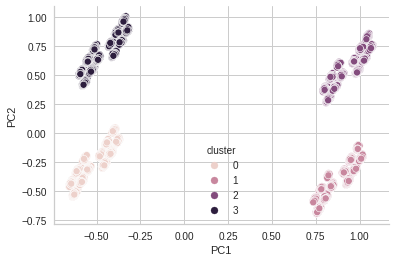

In [ ]:
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'cluster', data = pca_df)
sns.despine()

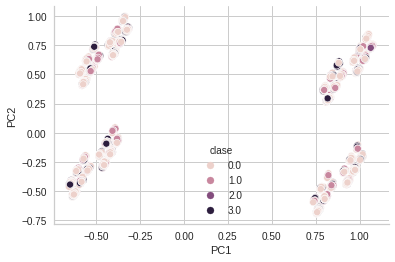

In [ ]:
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'clase', data = pca_df)
sns.despine()

In [ ]:
clusters_df.to_csv('drive/My Drive/ML/clusters.csv')

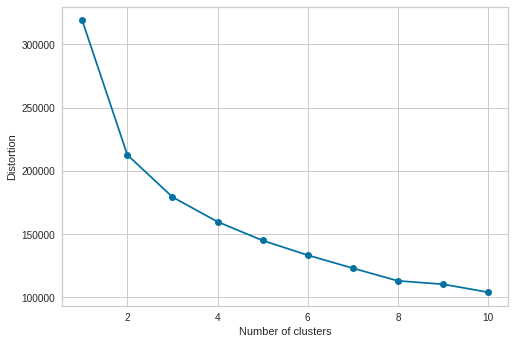

In [ ]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300)
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

2


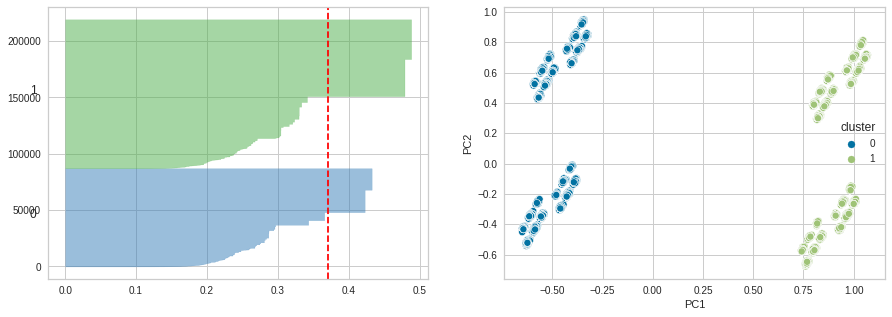

3


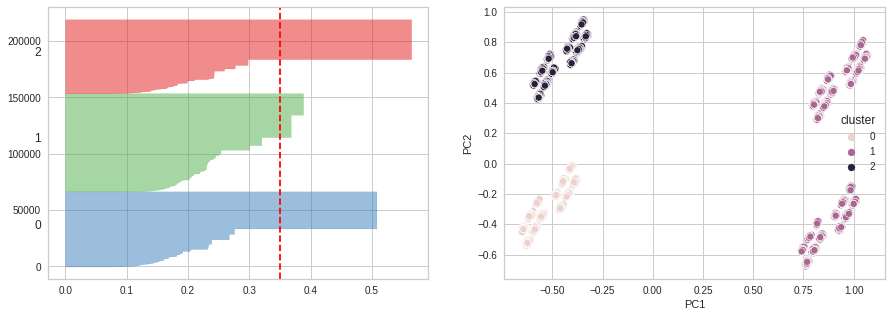

4


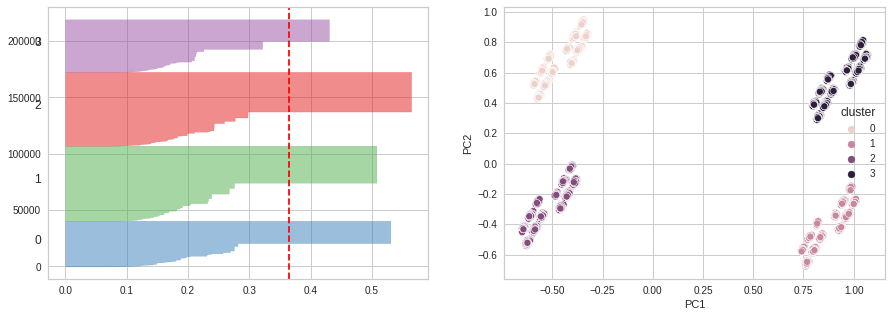

5


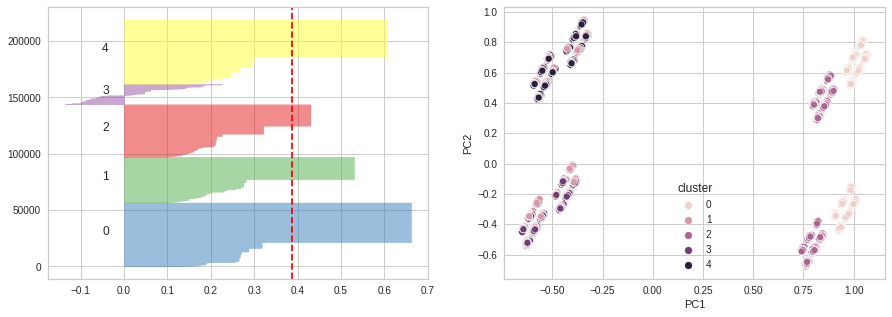

6


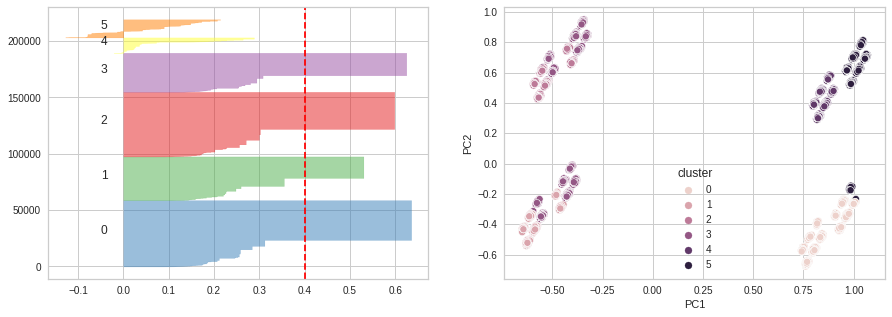

7


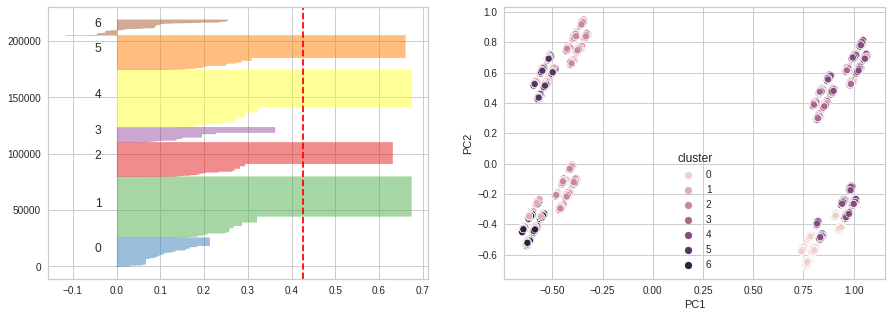

8


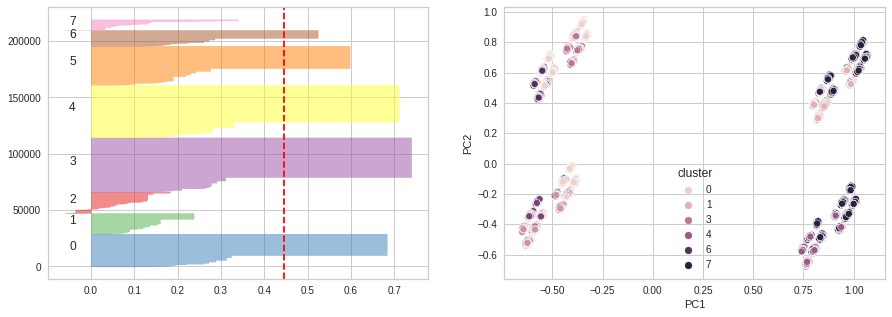

9


KeyboardInterrupt: ignored

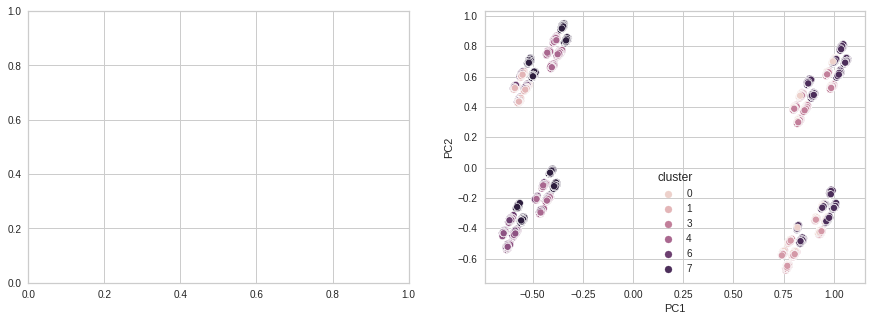

In [ ]:
for k in range(2,11):
  print(k)
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  '''
  Create KMeans instance for different number of clusters
  '''
  km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
  
  # plot scatter plot
  y_km = km.fit_predict(X)
  pca_df['cluster'] = y_km
  sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'cluster', data = pca_df, ax = ax[1])

  # silhouette plot
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[0])
  visualizer.fit(X)
  plt.show()

## Balancear datos

In [ ]:
y_column = 'CLASIFICACION'
final_columns = prediction_df.columns.drop(y_column)

In [ ]:
def under_sample(X, y, method = 'tomek'):
  if method == 'tomek':
    under = under_sampling.TomekLinks(sampling_strategy='not minority', return_indices=False)
  else:
    under = under_sampling.OneSidedSelection(n_neighbors=1, n_seeds_S=200)
    
  xnew, ynew = under.fit_resample(X, y)
  return xnew, ynew

def over_sample(X, y):
  # over sampling
  smote = over_sampling.SMOTE(sampling_strategy="not majority")
  X_sm, y_sm = smote.fit_resample(X, y)
  return X_sm, y_sm

In [ ]:
prediction_df.groupby('CLASIFICACION').count()

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_MÉXICO
CLASIFICACION,,,,,,,,,,,,,,,
0,161119,161119,161119,161119,161119,161119,161119,161119,161119,161119,161119,161119,161119,161119,161119
1,32960,32960,32960,32960,32960,32960,32960,32960,32960,32960,32960,32960,32960,32960,32960
2,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585,1585
3,23498,23498,23498,23498,23498,23498,23498,23498,23498,23498,23498,23498,23498,23498,23498


## Crear conjuntos de entrenamiento

In [ ]:
def get_training_set(df, test_size, y_column, under = None, over = False):
  columns = df.columns.drop(y_column)
  train, test = train_test_split(df, test_size=test_size)

  xtest=test[columns].astype('int')
  ytest=test[y_column].astype('int')

  extra = ''

  xtrain = train[columns].astype('int')
  ytrain = train[y_column].astype('int')

  if over:
    print('over sampling')
    xtrain, ytrain = over_sample(xtrain, ytrain)
    extra += '_over'
  
  if under:
    print('under sampling')
    xtrain, ytrain = under_sample(xtrain, ytrain, method = under)
    extra += f'_{under}'

  # guardar test set en csv
  test_filename = f'drive/My Drive/ML/test{extra}.csv'
  test.to_csv(test_filename)

  # guardar training set en csv
  train_df = pd.DataFrame(xtrain.copy())
  train_df.columns = columns
  train_df[y_column] = ytrain

  train_filename = f'drive/My Drive/ML/test{extra}.csv'
  train_df.to_csv(test_filename)

  return xtrain, ytrain, xtest, ytest, train_df

## Funciones auxiliares

In [ ]:
def evaluate_model(model, xtest, ytest, ypred = None):
  if ypred is None:
    ypred = model.predict(xtest)

  print("Precision = {:.4f}".format(precision_score(ytest, ypred, average='macro')))
  print("Recall = {:.4f}".format(recall_score(ytest, ypred, average='macro')))
  print("Accuracy = {:.4f}".format(accuracy_score(ytest, ypred)))
  #print("F1-score = {:.4f}".format(f1_score(ytest, ypred)))
  print('\nClasification Report:')
  print(classification_report(ytest, ypred))
  print(confusion_matrix(ytest, ypred))

In [ ]:
def get_best_tree(xtrain, ytrain, xtest, ytest):
  tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'auto']
  }
  grid_search = GridSearchCV(estimator = tree.DecisionTreeClassifier(), 
                           param_grid = tree_params,
                           n_jobs = -1,
                           scoring="recall_macro",
                           cv=3,
                           verbose = 0
                           ) 
  grid_search.fit(xtrain, ytrain)
  print('Best tree:')
  print(grid_search.best_params_)

  modelo_arbol = grid_search.best_estimator_
  evaluate_model(modelo_arbol, xtest, ytest)

  return modelo_arbol

In [ ]:
def get_best_nb(xtrain, ytrain, xtest, ytest):
  nb_params = {
    'var_smoothing': [1e-09, 1e-07, 1e-05, 1e-12]
  }
  grid_search = GridSearchCV(estimator = GaussianNB(), 
                           param_grid = nb_params,
                           n_jobs = -1,
                           scoring="recall_macro",
                           cv=3,
                           verbose = 0
                           ) 
  grid_search.fit(xtrain, ytrain)
  print('Best Naive Bayes:')
  print(grid_search.best_params_)

  modelo_nb = grid_search.best_estimator_
  evaluate_model(modelo_nb, xtest, ytest)

  return modelo_nb

In [ ]:
def get_best_random_forest(xtrain, ytrain, xtest, ytest, depth = False):
  rf_params = {
    'n_estimators': [1000,2000,3000],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'auto']
  }

  if depth:
    rf_params['max_depth'] = [5, 10, 13, 15],
  
  grid_search = GridSearchCV(estimator = RandomForestClassifier(), 
                           param_grid = rf_params,
                           n_jobs = -1,
                           scoring="recall_macro",
                           cv = 2,
                           verbose = 3
                           ) 
  grid_search.fit(xtrain, ytrain)
  print('Best random forest:')
  print(grid_search.best_params_)

  modelo_rf = grid_search.best_estimator_
  evaluate_model(modelo_rf, xtest, ytest)

  return modelo_rf

In [ ]:
def get_xgboost(xtrain, ytrain, xtest, ytest):
  param = {
      'eta': 0.3, 
      'max_depth': 13,  
      'objective': 'multi:softprob',  
      'num_class': ytrain.nunique()} 

  steps = 200

  # transformar datos para xgboost
  D_train = xgb.DMatrix(xtrain, label=ytrain)
  D_test = xgb.DMatrix(xtest, label=ytest)

  modelo_xgb = xgb.train(param, D_train, steps)

  preds = model.predict(D_test)
  best_preds = np.asarray([np.argmax(line) for line in preds])

  print('XG Boost')
  evaluate_model(model, xtest, ytest, ypred=best_preds)

  return modelo_xgb

## Evaluar modelos

### Datos completos

In [ ]:
y_column = 'CLASIFICACION'
xtrain, ytrain, xtest, ytest, train_df = get_training_set(final_df, 0.2, y_column, under = None, over = False)
display(train_df.groupby(y_column).count())
'''
modelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
#print()
#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)
'''

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,ENTIDAD_RES_AGUASCALIENTES,ENTIDAD_RES_BAJA CALIFORNIA,ENTIDAD_RES_BAJA CALIFORNIA SUR,ENTIDAD_RES_CAMPECHE,ENTIDAD_RES_CHIAPAS,ENTIDAD_RES_CHIHUAHUA,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_COAHUILA DE ZARAGOZA,ENTIDAD_RES_COLIMA,ENTIDAD_RES_DURANGO,ENTIDAD_RES_GUANAJUATO,ENTIDAD_RES_GUERRERO,ENTIDAD_RES_HIDALGO,ENTIDAD_RES_JALISCO,ENTIDAD_RES_MICHOACÁN DE OCAMPO,ENTIDAD_RES_MORELOS,ENTIDAD_RES_MÉXICO,ENTIDAD_RES_NAYARIT,ENTIDAD_RES_NUEVO LEÓN,ENTIDAD_RES_OAXACA,ENTIDAD_RES_PUEBLA,ENTIDAD_RES_QUERÉTARO,ENTIDAD_RES_QUINTANA ROO,ENTIDAD_RES_SAN LUIS POTOSÍ,ENTIDAD_RES_SINALOA,ENTIDAD_RES_SONORA,ENTIDAD_RES_TABASCO,ENTIDAD_RES_TAMAULIPAS,ENTIDAD_RES_TLAXCALA,ENTIDAD_RES_VERACRUZ DE IGNACIO DE LA LLAVE,ENTIDAD_RES_YUCATÁN,ENTIDAD_RES_ZACATECAS
CLASIFICACION,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876,466876
1,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029,82029
2,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061
3,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579,67579
4,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168,723168


"\nmodelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\n#print()\n#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)\n"

### Datos del Valle de México

In [ ]:
y_column = 'CLASIFICACION'
xtrain, ytrain, xtest, ytest, train_df = get_training_set(prediction_df, 0.2, y_column, under = None, over = False)
display(train_df.groupby(y_column).count())
'''
modelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
#print()
#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)
'''

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_MÉXICO
CLASIFICACION,,,,,,,,,,,,,,,
0,128751,128751,128751,128751,128751,128751,128751,128751,128751,128751,128751,128751,128751,128751,128751
1,26501,26501,26501,26501,26501,26501,26501,26501,26501,26501,26501,26501,26501,26501,26501
2,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278
3,18799,18799,18799,18799,18799,18799,18799,18799,18799,18799,18799,18799,18799,18799,18799


"\nmodelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\n#print()\n#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)\n"

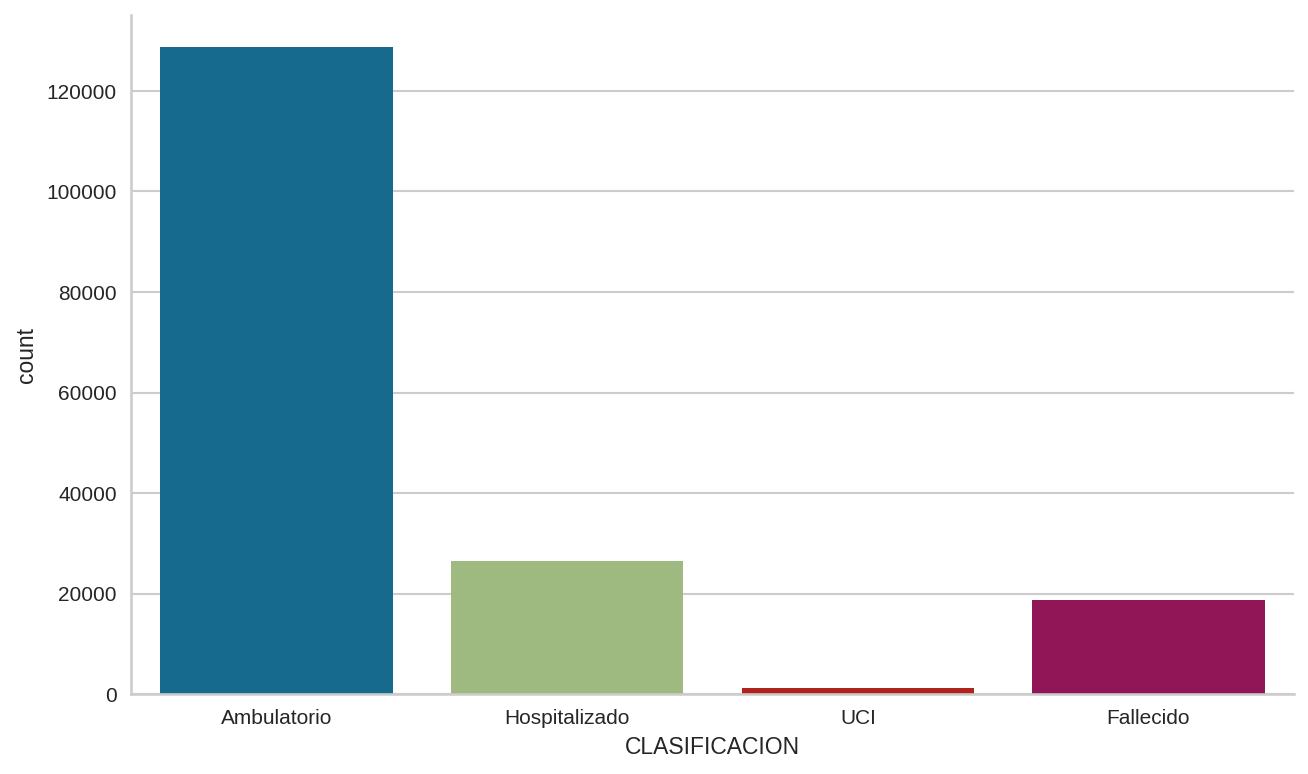

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(x = 'CLASIFICACION', data = train_df)
ax.set_xticklabels(['Ambulatorio', 'Hospitalizado', 'UCI', 'Fallecido'])
sns.despine()

In [ ]:
y_column = 'CLASIFICACION'
xtrain, ytrain, xtest, ytest, train_df = get_training_set(prediction_df, 0.2, y_column, under = 'oss', over = False)
display(train_df.groupby(y_column).count())
'''
modelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
#print()
#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)b
'''

under sampling


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_MÉXICO
CLASIFICACION,,,,,,,,,,,,,,,
0,93127,93127,93127,93127,93127,93127,93127,93127,93127,93127,93127,93127,93127,93127,93127
1,24375,24375,24375,24375,24375,24375,24375,24375,24375,24375,24375,24375,24375,24375,24375
2,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260
3,17540,17540,17540,17540,17540,17540,17540,17540,17540,17540,17540,17540,17540,17540,17540


"\nmodelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\n#print()\n#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)b\n"

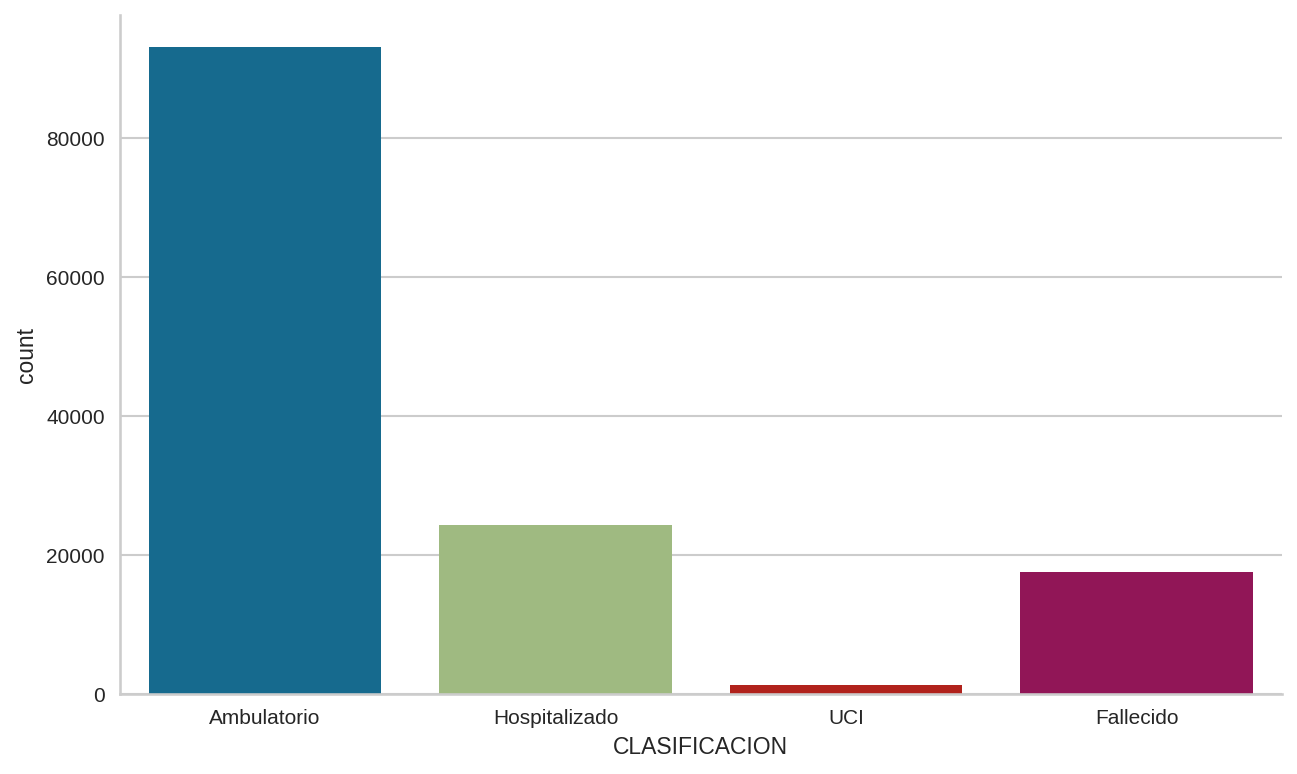

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(x = 'CLASIFICACION', data = train_df)
ax.set_xticklabels(['Ambulatorio', 'Hospitalizado', 'UCI', 'Fallecido'])
sns.despine()

In [ ]:
y_column = 'CLASIFICACION'
xtrain, ytrain, xtest, ytest, train_df = get_training_set(prediction_df, 0.2, y_column, under = None, over = True)
display(train_df.groupby(y_column).count())
'''
modelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
#print()
#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)b
'''

over sampling


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_MÉXICO
CLASIFICACION,,,,,,,,,,,,,,,
0,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928
1,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928
2,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928
3,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928,128928


"\nmodelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\n#print()\n#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)b\n"

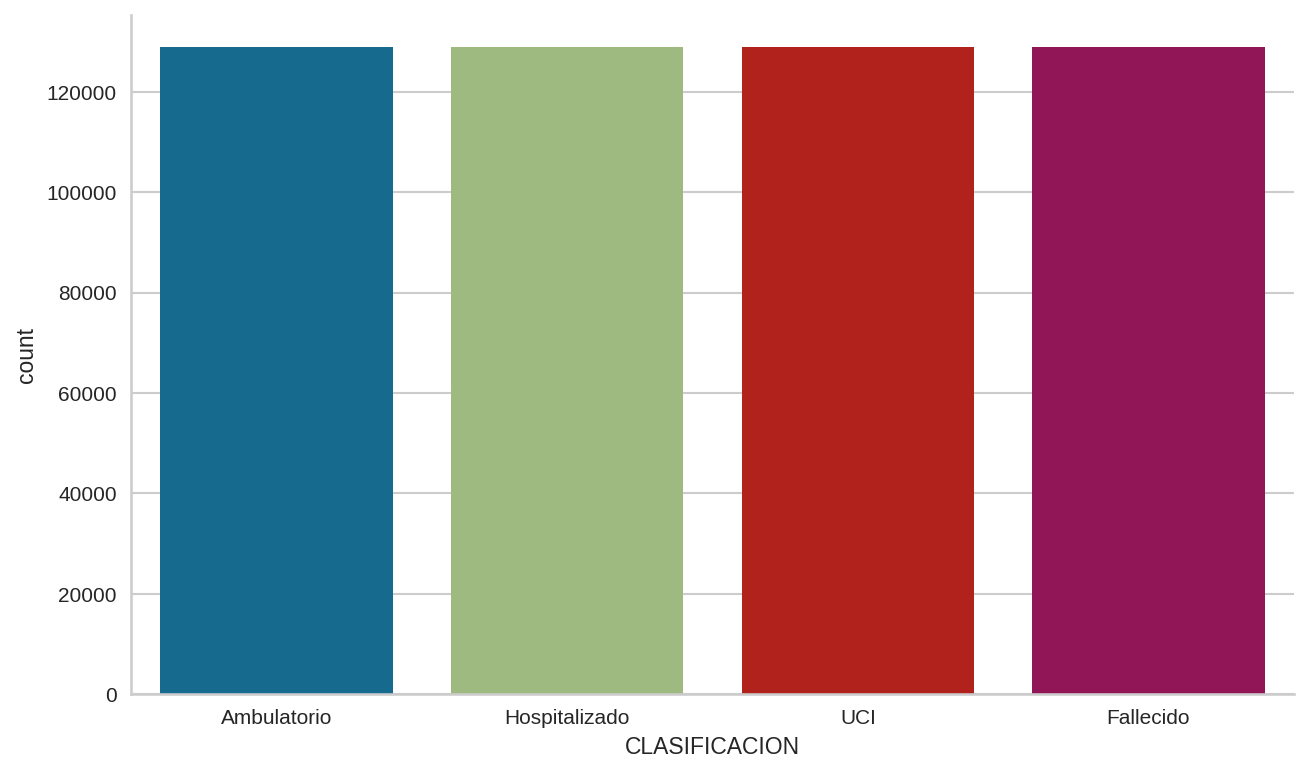

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(x = 'CLASIFICACION', data = train_df)
ax.set_xticklabels(['Ambulatorio', 'Hospitalizado', 'UCI', 'Fallecido'])
sns.despine()

In [ ]:
y_column = 'CLASIFICACION'
xtrain, ytrain, xtest, ytest, train_df = get_training_set(prediction_df, 0.2, y_column, under = 'oss', over = True)
display(train_df.groupby(y_column).count())
'''
modelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)
print()
print('-------'*12)
print()
modelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)
print() 
print('-------'*12)
#print()
#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)b
'''

over sampling


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


under sampling


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,SEXO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,ENTIDAD_RES_CIUDAD DE MÉXICO,ENTIDAD_RES_MÉXICO
CLASIFICACION,,,,,,,,,,,,,,,
0,128992,128992,128992,128992,128992,128992,128992,128992,128992,128992,128992,128992,128992,128992,128992
1,127808,127808,127808,127808,127808,127808,127808,127808,127808,127808,127808,127808,127808,127808,127808
2,124056,124056,124056,124056,124056,124056,124056,124056,124056,124056,124056,124056,124056,124056,124056
3,111440,111440,111440,111440,111440,111440,111440,111440,111440,111440,111440,111440,111440,111440,111440


"\nmodelo_arbol = get_best_tree(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_nb = get_best_nb(xtrain, ytrain, xtest, ytest)\nprint()\nprint('-------'*12)\nprint()\nmodelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest)\nprint() \nprint('-------'*12)\n#print()\n#modelo_xgb = get_xgboost(xtrain, ytrain, xtest, ytest)b\n"

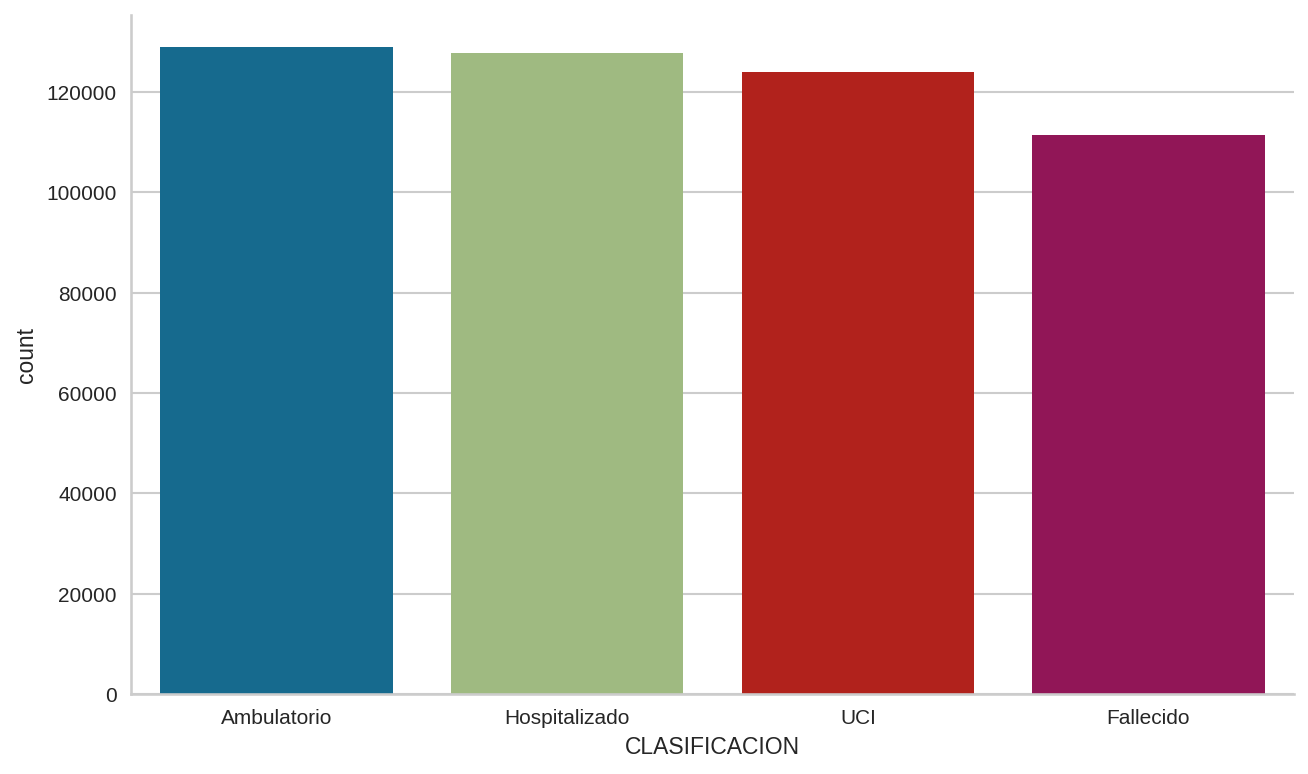

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi = 150)
sns.countplot(x = 'CLASIFICACION', data = train_df)
ax.set_xticklabels(['Ambulatorio', 'Hospitalizado', 'UCI', 'Fallecido'])
sns.despine()

### Datos sin ambulatorios

In [ ]:
prediction_df2 = prediction_df[prediction_df['CLASIFICACION'] != 0]

In [ ]:
y_column = 'CLASIFICACION'
xtrain, ytrain, xtest, ytest, train_df = get_training_set(prediction_df2, 0.2, y_column, under = 'oss', over = True)
display(train_df.groupby(y_column).count())
modelo_rf = get_best_random_forest(xtrain, ytrain, xtest, ytest, depth = True)
print() 
print('-------'*12)